In [5]:
%run ./imports.ipynb

# dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [6]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [7]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

In [8]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)

In [9]:
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [11]:
%run ./preprocessing.ipynb

In [12]:
df['clean_text'] = df.complaint_text.apply(lambda x: clean(x))
df['lem'] =  df.clean_text.apply(lambda x: lem(x))
df = df[['complaint_text','lem','category']]
df['after_POS'] =  df.lem.apply(lambda x: spacy_clean(x))

In [24]:

df['clean'] = df['after_POS'].str.replace('xxxx','')
df['clean'] = df['clean'].str.replace('-PRON-', '')
# df = df_clean.drop(['complaint_POS_removed'],axis = 1)

In [52]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = tfidf.fit_transform(df.clean)
tfidf.get_feature_names_out()[:10]

array(['aarp', 'abandonment', 'abatement', 'abbreviation', 'abd',
       'abhorrent', 'abide', 'ability', 'abovementione', 'abovereference'],
      dtype=object)

In [51]:
len(tfidf.get_feature_names_out())

6485

In [42]:
# initialize NMF
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=5, random_state=40)
W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.02,0.02,0.01,0
Doc1,0.01,0.02,0.00,0.00,0.01,1
Doc2,0.00,0.03,0.00,0.04,0.00,3
Doc3,0.02,0.03,0.01,0.05,0.01,3
Doc4,0.07,0.00,0.01,0.00,0.00,0


In [ ]:
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]


In [ ]:
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df['clean']))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
# df_doc_topic.head()

In [43]:
df['Topic'] = significant_topic

In [44]:
pd.set_option('display.max_colwidth', None)

In [49]:
# temp =df[['complaint_text','clean','category','Topic']].groupby('Topic').head(10)
# temp.sort_values('Topic')

In [50]:
topic_mapping = {
    0: 'Bank Account services',
    1: 'Theft/Dispute Reporting',
    2: 'Credit card or prepaid card',
    3: 'Others',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df['Topic'] = df['Topic'].map(topic_mapping)

<Axes: xlabel='Topic', ylabel='count'>

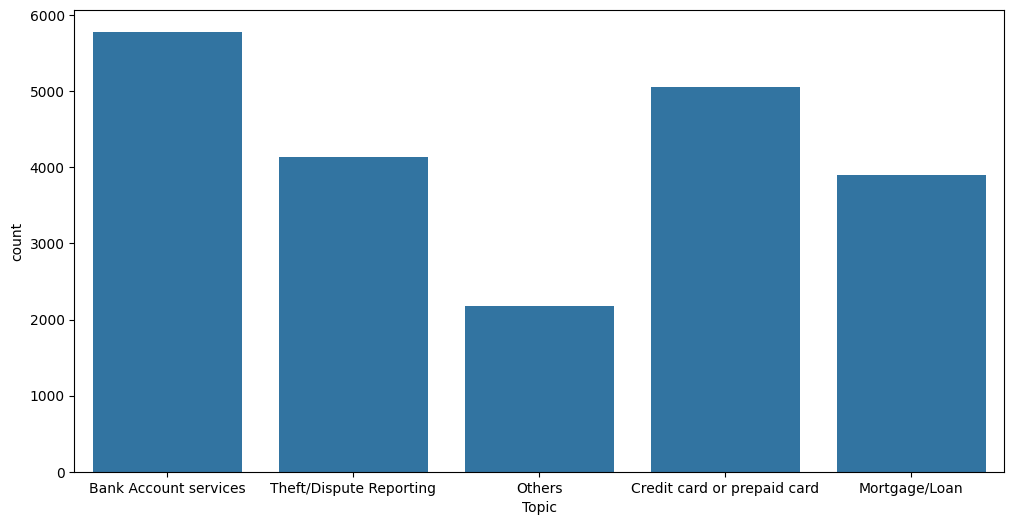

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=df)

In [48]:
df.Topic.value_counts()

Topic
Bank Account services          5783
Credit card or prepaid card    5062
Theft/Dispute Reporting        4141
Mortgage/Loan                  3904
Others                         2182
Name: count, dtype: int64